### This notebook estimates the maximum number of electrons per pixel the Starlink satellites would produce.
* We assume a satellite is at 1200km height, and 40 degree off zenith. The angular velocity is about 0.5 deg/sec.
* Because the satellites are at finite distances from the observatory, the FWHM of the trail is estimated as the following -

    FWHM = $\sqrt{\frac{D_{sat}^2}{d^2} + \frac{D_{pupil}^2}{d^2} + \theta_{atm}^2}$, 
    
    where $D_{sat} \sim$ 2m is the size of the satellite,
    $d$ = 1200km/cos(zenith angle) is the distance from the observatory to the satellite, and
    $\theta_{atm}$ = 0.7 arcsec is the LSST seeing.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import galsim
import matplotlib.pyplot as plt
import os
from lsst.utils import getPackageDir 
from LEOSat import getSatSII

In [2]:
angularV = 0.5*60 # in deg/min, 0.5 deg/sec, for 40 degree zenith angle, and satellite orbit going through zenith

#### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. 

In [3]:
# full_well for a 30s visit, in e-
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.
xtalk_limit = 10e3 

#### We first determine what fraction of the flux will be in the center/brightest pixel

In [4]:
#Assume it moves along pixel grid. The time its image center moves from one pixel center to the next is dt
dt = 0.2/(angularV/60*3600) # in seconds

In [5]:
#satellite parameters
l1 = 2 #1.5 #meter
l2 = 2 #meter
h = 1200e3

In [6]:
f=10.3
d=8.36
pixel_size = 10 #micron
plate_scale = 0.2
e = 0.61
seeing = 0.7
zangle = 40

#see doublePeak.ipynb
[sii, fwhm_exp] = getSatSII(f,d,e, l1, l2, h, zangle, seeing, pixel_size, plate_scale)

donutR = 27 micron, satellite conv kernel = 13 x 13 microns
padding =  5
expected FWHM = 66 microns


#### Approximate it as a source which appears at one pixel center for dt, then disappears from there, and instantly appears at the next pixel center for dt. During each dt, the source deposit a flux profile that is SII (satellite instantaneous image)
So we are just overlapping SIIs whose centers are 0.2 arcsec apart. Considering that the FWHM is much larger than pixel size, the top of the SIIs are pretty flat. So this should be a pretty good approximation.
This slightly overestimates the flux, because having the SIIs moving across the pixel in dt would yield a smaller flux for the pixel, compared to when the peak intensity of the SIIs is overlapped with the pixel center during dt.

In [7]:
aa = np.sum(sii,axis=0)
idx = np.argmax(aa==max(aa))
ratio = sum(aa[idx-4:idx+6])
print('peak pixel flux/total flux = %.4f'%ratio)

peak pixel flux/total flux = 0.1643


### Baseline LSST system, as defined in syseng_throughput

In [8]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations

In [9]:
exptime=15 
nexp=2
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
effarea=np.pi*(6.423/2*100)**2
X=1.0

# PhotometricParameters object for standard m5 calculations.
photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)

### Let's make sure we can reproduce standard m5 results

In [10]:
m5 = st.makeM5(hardware, system, darksky=None, 
                      exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                      effarea=effarea, X=1.0)

In [11]:
m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


Set up the dataframe

In [12]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
properties = ['SatLim']
d = pd.DataFrame(index=filterlist, columns=properties, dtype='float')

### Satellites have solar SED

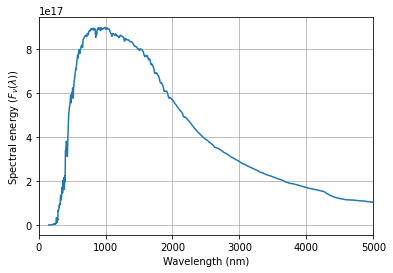

In [13]:
satellite = Sed()
satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
satellite.flambdaTofnu()
plt.plot(satellite.wavelen, satellite.fnu)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Spectral energy ($F_\nu(\lambda)$)')
plt.xlim([0, 5000])
plt.grid()

### Calculate the saturation limits under darksky: the source should have solar SED

In [14]:
# change exposure to dt
photParams_dt = PhotometricParameters(exptime=dt, nexp=1,
                                           gain=1.0, effarea=effarea, readnoise=readnoise,
                                           othernoise=othernoise, darkcurrent=darkcurrent)
key = 'SatLim'
for f in system:
    satellite = Sed()
    satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                             'data', 'kurucz_sun.gz'))
    fNorm = satellite.calcFluxNorm(0, system[f])
    # print('fNorm = %.2e'%fNorm)
    satellite.multiplyFluxNorm(fNorm)
    adu = satellite.calcADU(system[f], photParams=photParams_dt)
    #print(satellite.calcMag(system[f]))
    
    flatsource = Sed()
    flatsource.setFlatSED()
    adu_flat = flatsource.calcADU(system[f], photParams=photParams_dt)
    print('%s, adu = %e, adu_flat = %e, diff = %.2f'%(f, adu, adu_flat, adu-adu_flat))
    #So the ADU is the same as using the flat SED. Does that make sense?
    #yes, according to Lynne. Because the AB magnitude, and the flux, both include the effect of the bandpass (throughput)
    #therefore are specific for each observatory. That is why calcFluxNorm() has system[f] as input.
    #The mapping from mag to flux inside a particular bandpass is unique, and have nothing to do with SED
    
    adu0 = adu*ratio
    #because we assumed a m=0 star
    # we use gain=1.0, so adu = number of e-
    # we also get rid of skycounts from each pixel. This has miminal effect on results
    d[key].loc[f] = np.log10(adu0/(full_well-m5.skyCounts.loc[f]))/2*5

r, adu = 2.073579e+07, adu_flat = 2.073579e+07, diff = -0.00
i, adu = 1.576086e+07, adu_flat = 1.576086e+07, diff = 0.00
u, adu = 7.070173e+06, adu_flat = 7.070173e+06, diff = -0.00
z, adu = 1.092646e+07, adu_flat = 1.092646e+07, diff = -0.00
g, adu = 2.543741e+07, adu_flat = 2.543741e+07, diff = 0.00
y, adu = 5.257237e+06, adu_flat = 5.257237e+06, diff = -0.00


#### Double-check: do the same calculation using zero points

In [15]:
d_zp = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
key = 'SatLim'
for f in system:
    #number of electrons we can accomodate for the source in dt sec
    ne = (full_well-m5.skyCounts[f])/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/dt
    d_zp[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [16]:
d_zp

,SatLim
u,2.223337
g,3.615839
r,3.396921
i,3.101654
z,2.708359
y,1.918370


In [17]:
round(d_zp - d)  #should be idential to above calculations

,SatLim
u,0.0
g,-0.0
r,0.0
i,-0.0
z,0.0
y,0.0


### Make peak electron counts vs. mag plot

In [18]:
pRatio = ratio
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']
d_plot = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float')

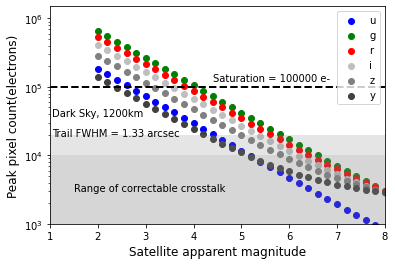

In [19]:
magLow = 1
fig, ax = plt.subplots()
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    flatsource = Sed()
    flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
    adu = flatsource.calcADU(system[f], photParams=photParams_dt)
    adu0 = adu*pRatio #a m=0 start produces this adu0 in the center pixel
    for m in range(31):
        mag = magLow+1 + 0.2 * m
        mags.append(mag)
        npeak = adu0*10**(-mag/2.5)+m5.skyCounts[f]
        npeaks.append(npeak)
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
    d_plot.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
#plt.plot([magLow, magLow+7.0],[xtalk_limit, xtalk_limit], ls = '--', lw = 2, color='black')
plt.text(magLow+0.5, xtalk_limit*0.3, "Range of correctable crosstalk", color = 'black')
#plt.text(0.5, xtalk_limit*0.3, "crosstalk = %d e-"%xtalk_limit, color = 'black')
plt.plot([magLow+0,magLow+7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(magLow+3.4, full_well2*1.20, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.13, 0.43, "Trail FWHM = %.2f arcsec"%(fwhm_exp/pixel_size*plate_scale), color = 'black', transform=fig.transFigure)
plt.text(0.13, 0.5, "Dark Sky, 1200km", color = 'black', transform=fig.transFigure)
plt.legend(loc='upper right')
plt.fill_between([magLow+0,magLow+7.0], [xtalk_limit, xtalk_limit], facecolor='grey', alpha=0.15)
plt.fill_between([magLow+0,magLow+7.0], [2e4, 2e4], facecolor='grey', alpha=0.2)
plt.yscale('log')
plt.xlim(magLow+0,magLow+7.0)
plt.ylim(1e3, 1.5e6)
#plt.grid()
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);
plt.savefig('Peak_count_by_band_1200km_darkSky.pdf')

In [20]:
#check consistency with above calculations.
d_plot.join(d)

,SatLimFromPlot,SatLim
u,2.4,2.223495
g,3.8,3.615996
r,3.4,3.397078
i,3.2,3.101811
z,2.8,2.708516
y,2.0,1.918527


#### Now do the same thing for bright sky. We will only do the calculations using zero points below.

In [21]:
#values from DECam. These are ~50 deg from full moon. See http://www.ctio.noao.edu/noao/node/5826
skyBrightMag = {'u': 17.7, 'g':19.4, 'r':19.7, 'i':19.4, 'z':18.2, 'y':17.7}

#### We will add additional 0.4 mag to the sky background, due to solar cycle

Even the 
11 yr solar cycle gives 0.5 mag change in v band.  For our immediate 
SpaceX purpose it would be appropriate to generate only two plots, one 
for bright time and one for dark time.  In the mid 2020s we enter solar 
max, so add 0.4 mag in v band to sky.

In [22]:
skyCounts = {}
for f in system:
    skyCount = 10**((0.4+m5.skyMag[f]-skyBrightMag[f])/2.5)*m5.skyCounts[f] # we can actually simply calculate sky count this way.
    skyCounts[f]=skyCount
    print(f, skyCount)

u 14856.66923227248
y 7926.79830507322
g 8261.238714700821
r 4696.910335856309
z 9353.643864016844
i 4575.579983868398


In [23]:
#use zero points to calculate saturation magnitudes under bright sky
d_zp_bright = pd.DataFrame(index=filterlist, columns=properties, dtype='float')
for f in system:
    key = 'SatLim'
    #number of electrons we can accomodate for the source in dt sec
    ne = (full_well-skyCounts[f])/ratio
    #number of electrons we can accomodate for this source in 1 sec
    ne = ne/(dt)
    d_zp_bright[key].loc[f] = (m5.Zp_t[f]-2.5*np.log10(ne))

In [24]:
d_zp_bright - d_zp

,SatLim
u,0.112656
g,0.058527
r,0.028598
i,0.025107
z,0.056924
y,0.041649


for 5th mag, under bright sky, band u, peak e per pixel = 26478
for 5th mag, under bright sky, band g, peak e per pixel = 50073
for 5th mag, under bright sky, band r, peak e per pixel = 38781
for 5th mag, under bright sky, band i, peak e per pixel = 30482
for 5th mag, under bright sky, band z, peak e per pixel = 27314
for 5th mag, under bright sky, band y, peak e per pixel = 16568


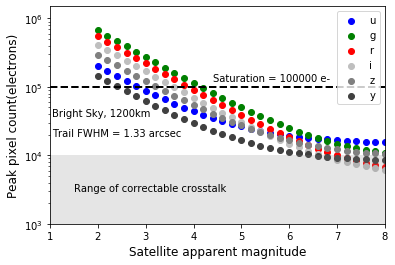

In [25]:
d_plot_zp_bright = pd.DataFrame(index=filterlist, columns=['SatLimFromPlot'], dtype='float') # b for bright sky
fig, ax = plt.subplots()
peak_e_mag_5 = []
for i,f in enumerate(filterlist):
    mags = []
    npeaks = []
    for m in range(31):
        mag = magLow+1.0 + 0.2 * m
        mags.append(mag)
        #for a source of mag, how many electrons is produced on detector in a second?
        ne = 10**((m5.Zp_t[f] - mag)/2.5)
        # what about dt seconds
        ne *= dt
        # how many fall into the center pixel? on top of the background and others
        npeak = ne*pRatio+ skyCounts[f]
        npeaks.append(npeak)
        d_plot_zp_bright.SatLimFromPlot.loc[f] = mags[np.argmax(np.array(npeaks)<full_well)]
        if mag==5.0:
            peak_e_mag_5.append(npeak)
            print('for 5th mag, under bright sky, band %s, peak e per pixel = %.0f'%(f,npeak))
    plt.scatter(mags, npeaks, label=f, color=colors[i])
    #print(npeak)
    #break
#plt.plot([magLow, magLow+7.0],[xtalk_limit, xtalk_limit], ls = '--', lw = 2, color='black')
plt.text(magLow+0.5, xtalk_limit*0.3, "Range of correctable crosstalk", color = 'black')
#plt.text(0.5, xtalk_limit*0.3, "crosstalk = %d e-"%xtalk_limit, color = 'black')
plt.plot([magLow+0,magLow+7.0],[full_well2, full_well2], ls = '--', lw = 2, color='black')
plt.text(magLow+3.4, full_well2*1.20, "Saturation = %d e-"%full_well2, color = 'black')
plt.text(0.13, 0.43, "Trail FWHM = %.2f arcsec"%(fwhm_exp/pixel_size*plate_scale), color = 'black', transform=fig.transFigure)
plt.text(0.13, 0.5, "Bright Sky, 1200km", color = 'black', transform=fig.transFigure)
plt.legend(loc='upper right')
plt.fill_between([magLow+0,magLow+7.0], [xtalk_limit, xtalk_limit], facecolor='grey', alpha=0.2)
plt.yscale('log')
plt.xlim(magLow+0,magLow+7.0)
plt.ylim(1e3, 1.5e6)
#plt.grid()
plt.xlabel('Satellite apparent magnitude', fontsize=12)
plt.ylabel('Peak pixel count(electrons)', fontsize=12);
plt.savefig('Peak_count_by_band_1200km_brightSky.pdf')

### what is the surface brightness of the satellite trail?
The instantaneous surface brightness of the satellite is simply the surface brightness if the satellite is stationary relative to our detector.
So here the "surface brightness of the satellite trail" is actually the surface brightness averaged over a period of time. Therefore this surface brightness is dependent on the averaging time. We assume a 30s exposure, or 2x15s exposures.

In [26]:
fNormTrail = dt/(nexp*exptime)*ratio/photParams_std.platescale**2
dmag = -2.5*np.log10(fNormTrail)
print(dmag)

12.043997008408558


In [27]:
m = 5  #just pick a random mag; won't affect the mag difference below.
for i,f in enumerate(filterlist):
    satellite = Sed()
    satellite.readSED_flambda(os.path.join(getPackageDir('sims_movingObjects'),
                                         'data', 'kurucz_sun.gz'))
    fNorm = satellite.calcFluxNorm(m, system[f])
    satellite.multiplyFluxNorm(fNorm) #normalize the passband to mag=m
    satellite.multiplyFluxNorm(fNormTrail) #further dilute the light by a factor of fNormTrail
    mTrail = satellite.calcMag(system[f])
    print('%s, %.2f'%(f, mTrail-m))

u, 12.04
g, 12.04
r, 12.04
i, 12.04
z, 12.04
y, 12.04
